# CONDITIONAL GENERATIVE ADVERSARIAL NETWORKS (CGAN)
In an unconditioned generative model, there is no control on modes of the data being generated. However, this can be extended to conditional model if both the generator and discriminator are conditioned on some additional information $y$. $y$ can be any kind of auxiliary information such as the class labels etc. The conditioning can be performed by adding the additional information $y$ as an additional input layer into the both the discriminator and generator. This direct the data generation process. a Conditional GAN allows us to direct the Generator to synthesize the kind of fake examples we want.


In order to fool the Discriminator, it is not enough for the CGAN Generator to produce only realistic-looking data but it should be able to match the generated examples to their labels so that  when the Generator is fully trained, the generator will be able to synthesize the examples we want based on the label it receive 




![](../images/cgan.JPG)
[source of image](https://arxiv.org/pdf/1411.1784.pdf)

In [1]:
#!pip install git+https://github.com/tensorflow/docs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf
from tensorflow import keras as K
from tensorflow_docs.vis import embed

In [32]:
plt.rcParams['image.cmap']='gray'

In [33]:
(train_x,y_labels),(_,_)=K.datasets.mnist.load_data()
train_x[1].shape

(28, 28)

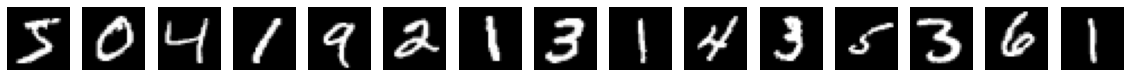

In [34]:
n=15
plt.figure(figsize=(20,24))
for i in range(n):
    plt.subplot(1,15,i+1)
    plt.imshow(train_x[i])
    plt.axis('off')


In [35]:
len(train_x),len(y_labels)

(60000, 60000)

In [36]:
latent_dim=100
batch_size=150
num_classes=10
num_channels = 1

In [37]:
def process_data(x,y,n_class=10):
    x=x.astype(np.float32)
    x=(x-127.5)/127.5
    x=x.reshape(-1,28,28,1)
    y=K.utils.to_categorical(y,n_class)
    return x,y
    
train_x,y_labels=process_data(train_x,y_labels)

In [38]:
np.min(train_x[1]),np.max(train_x[1])

(-1.0, 1.0)

In [39]:
train_d=tf.data.Dataset.from_tensor_slices((train_x,y_labels)).shuffle(1000).batch(batch_size)

In [40]:
for x,y in train_d:
    print(f"Shape of a batch of training images: {x.shape}")
    print(f"Shape of a batch of  training labels: {y.shape}")
    break

Shape of a batch of training images: (150, 28, 28, 1)
Shape of a batch of  training labels: (150, 10)


In [41]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
K.backend.clear_session()
init_w=K.initializers.RandomNormal(mean=0,stddev=0.2)

In [42]:
generator_in_channels

110

In [43]:
discriminator=K.models.Sequential([
                     K.layers.InputLayer(input_shape=(28,28,discriminator_in_channels)),
    
                     K.layers.Conv2D(64,kernel_size=4,strides=2,padding='same'),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Conv2D(100,kernel_size=4,strides=2,padding='same'),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Flatten(),
                     K.layers.Dropout(0.2),
                     K.layers.Dense(1)
                                   ],name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        11328     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 100)         102500    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 100)         0         
                                                                 
 flatten (Flatten)           (None, 4900)              0         
                                                                 
 dropout (Dropout)           (None, 4900)              0         
                                                                 
 dense (Dense)               (None, 1)               

In [44]:
generator =K.Sequential( [
        K.layers.InputLayer(input_shape=(generator_in_channels,)),
        K.layers.Dense(8*8*generator_in_channels,use_bias=False),
        K.layers.ReLU(),
        K.layers.Reshape((8, 8, generator_in_channels)),
        K.layers.UpSampling2D(),
    
        K.layers.Conv2D(64, kernel_size=4, padding="same",kernel_initializer=init_w,use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),
        K.layers.Conv2DTranspose(128, kernel_size=4, strides=1, padding="same",use_bias=False ),
        K.layers.ReLU(),
        
        K.layers.Conv2D(128, kernel_size=4,  padding="same",use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),
       
        K.layers.UpSampling2D(),
    
        K.layers.Conv2D(1, kernel_size=5, activation="tanh",use_bias=False)
                          ],'generator')
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 7040)              774400    
                                                                 
 re_lu (ReLU)                (None, 7040)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 110)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 110)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        112640    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                           

In [45]:
class CGAN(K.Model):
    def __init__(self,discriminator,generator,latent_dim,n_critic=5,gp_weights=10.0):
        super(CGAN,self).__init__()
        self.discriminator=discriminator
        self.generator=generator
        self.latent_dim=latent_dim
        self.gp_weights=gp_weights
        self.n_critic=n_critic
        self.d_loss_metrics=K.metrics.Mean(name='d_loss')
        self.g_loss_metrics=K.metrics.Mean(name='g_loss')
    @property    
    def metrics(self):
        return [self.d_loss_metrics,self.g_loss_metrics]
    
    def compile(self,d_optimizer,g_optimizer):
        super(CGAN,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        
    @tf.function    
    def wasserstein_loss(self,real_outs,fake_outputs):
        real_l=tf.reduce_mean(real_outs)
        fake_l=tf.reduce_mean(fake_outputs)
        return fake_l - real_l
    @tf.function
    def generator_loss(self,fake_outputs):
        return -tf.reduce_mean(fake_outputs)
    
    def gradient_penalty(self,batch_size,real_imgs,fake_imgs):
        alpha=tf.random.normal([batch_size,1,1,1])
        interpolated_imgs=(alpha*real_imgs)+(1-alpha)*fake_imgs
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_imgs)
            interpolated_pred=self.discriminator(interpolated_imgs)
        grads=gp_tape.gradient(interpolated_pred,[interpolated_imgs])[0]
        #norm=tf.sqrt(tf.reduce_sum( tf.square(grads)),axis=[1,2,3])
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
        gp=tf.reduce_mean((norm-1)**2)
        return gp
    
    def train_step(self,data):
        real_images,one_hot_labels=data
        batch_size=tf.shape(real_images)[0]
        for _ in range(self.n_critic):
            # Add dummy dimensions to the labels so that they can be concatenated with the images
            image_one_hot_labels=one_hot_labels[:,:,None,None]
            image_one_hot_labels=tf.repeat(image_one_hot_labels,repeats=(28*28))
            image_one_hot_labels=tf.reshape(image_one_hot_labels,(-1,28,28,num_classes))
            
            # Get the latent vector
            z_random_latent_vectors=tf.random.normal([batch_size,self.latent_dim])
            z_random_vectors_one_hot_labels=tf.concat([z_random_latent_vectors,one_hot_labels],axis=1)
            
            with tf.GradientTape() as tape:
                generated_imgs=self.generator(z_random_vectors_one_hot_labels)
                fake_imgs_labels=tf.concat([generated_imgs,image_one_hot_labels],-1)
                real_imgs_labels=tf.concat([real_images,image_one_hot_labels],-1)
                
                fake_output_=self.discriminator(fake_imgs_labels)
                real_output_=self.discriminator(real_imgs_labels)
                
                d_loss_=self.wasserstein_loss(real_output_,fake_output_)
                
                g_penal=self.gradient_penalty(batch_size,real_imgs_labels,fake_imgs_labels)
                d_loss=d_loss_+self.gp_weights*g_penal
            
            d_grads=tape.gradient(d_loss,self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))
                
                
        image_one_hot_labels=one_hot_labels[:,:,None,None]
        image_one_hot_labels=tf.repeat(image_one_hot_labels,repeats=(28*28))
        image_one_hot_labels=tf.reshape(image_one_hot_labels,(-1,28,28,num_classes))       
        # Get the latent vector
        z_random_latent_vectors=tf.random.normal([batch_size,self.latent_dim])
        z_random_vectors_one_hot_labels=tf.concat([z_random_latent_vectors,one_hot_labels],axis=1)
        
        with tf.GradientTape() as tape:
            generated_imgs=self.generator(z_random_vectors_one_hot_labels)
            fake_ims_labels=tf.concat([generated_imgs,image_one_hot_labels],-1)
            fake_output=self.discriminator(fake_ims_labels)
            g_loss=self.generator_loss(fake_output)
        g_grads=tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
        
        self.d_loss_metrics.update_state(d_loss)
        self.g_loss_metrics.update_state(g_loss)
        return {'d_loss':self.d_loss_metrics.result(),"g_loss":self.g_loss_metrics.result()}
        

In [46]:
K.backend.clear_session()

In [47]:
cgan=CGAN(discriminator=discriminator,generator=generator,latent_dim=latent_dim)
cgan.compile(d_optimizer=K.optimizers.Adam( learning_rate=0.0002, beta_1=0.5, beta_2=0.9 ),
                g_optimizer=K.optimizers.Adam(  learning_rate=0.0002, beta_1=0.5, beta_2=0.9 ))

In [ ]:
cgan.fit(train_d,epochs=100,batch_size=batch_size)

In [ ]:
noise=tf.random.normal((1,latent_dim))
label_num=7
label=K.utils.to_categorical([label_num],num_classes)
label = tf.cast(label, tf.float32)
z_random_label=tf.concat([noise,label],1)
gen=cgan.generator.predict(z_random_label)
gen=tf.reshape(gen,(28,28))
plt.title('Digit: '+str(label_num))
plt.imshow(gen)
plt.axis('off')
plt.show()

In [50]:
noise=tf.random.normal((10,latent_dim))
labels_=[0,1,3,3,4,5,6,6,8,9]
labels=K.utils.to_categorical(labels_,num_classes)
noise_labels=tf.concat([noise,labels],1)
imgs=cgan.generator.predict(noise_labels)

n=9
plt.figure(figsize=(24,10))
for i in range(n):
  bx=plt.subplot(2,9,i+n+1)
  plt.title('Digit: '+str(labels_[i]))
  plt.imshow(tf.squeeze(imgs[i]))
  plt.axis('off')

In [52]:
noise=tf.random.normal((10,latent_dim))
labels_=[0,1,2,3,4,5,6,7,8,9]
labels=K.utils.to_categorical(labels_,num_classes)
noise_labels=tf.concat([noise,labels],1)
imgs=cgan.generator.predict(noise_labels)

In [ ]:
n=9
plt.figure(figsize=(24,10))
for i in range(n):
    bx=plt.subplot(2,9,i+n+1)
    plt.title('Digit: '+str(labels_[i]))
    plt.imshow(tf.squeeze(imgs[i]))
    plt.axis('off')

 reference
 
 - [Conditional GAN](https://keras.io/examples/generative/conditional_gan/ 'keras')
 
- [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
